# Обучение модели CV для классификации настроения

Цель - создание архитектуры модели CV и обучение ее для классификации настроения человека на фото

Данные - имеется размеченный набор фотографий, распределенный по двум папкам train и test. Сам набор данных взят с kaggle.

Загрузим все необходимые для работы библиотеки. Также подключим видеокарту для более быстрого обучения модели. 

In [1]:
import os
# Установка путей к CUDA 13.0
cuda_path = r'C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v13.0'
os.environ['CUDA_PATH'] = cuda_path

# Добавление необходимых путей в PATH
cuda_bin = os.path.join(cuda_path, 'bin')
cuda_libnvvp = os.path.join(cuda_path, 'libnvvp')

# Добавляем пути в начало PATH для приоритета
os.environ['PATH'] = cuda_bin + os.pathsep + cuda_libnvvp + os.pathsep + os.environ['PATH']

print("Пути CUDA 13.0 установлены!")

import shutil
from PIL import Image
import tensorflow as tf

import torch
print(f"CUDA доступна: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Версия CUDA в PyTorch: {torch.version.cuda}")
    print(f"Количество GPU: {torch.cuda.device_count()}")
    print(f"Имя устройства: {torch.cuda.get_device_name()}")

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet50_Weights
from collections import Counter
import re
import time
from tqdm import tqdm
import gc
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

Пути CUDA 13.0 установлены!
CUDA доступна: True
Версия CUDA в PyTorch: 12.1
Количество GPU: 1
Имя устройства: NVIDIA GeForce RTX 4070
Используется устройство: cuda


Подключим нашу папку с фотографиями. Зададим базовую папку в BASE_PATH и через path.join создадим пути к тренировочной и тестовой пакпке. Также создадим трансформеры для предобработки и аугментации данных, чтобы улучшить качество модели. После создадим датасеты с ипользованием трансформеров и путей к папкам.

In [3]:
BASE_PATH = r"C:\Users\User\Desktop\Нейронка для чая\data"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Изменение размера
    transforms.RandomHorizontalFlip(p=0.5), # Случайное отражение
    transforms.RandomRotation(10),          # Случайный поворот
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Изменение цветов
    transforms.ToTensor(),                  # Конвертация в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Нормализация ImageNet
                         std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root=TEST_PATH,
    transform=test_transform
)

Создадим DataLoader'ы с указанием размера батча.

In [15]:
BATCH_SIZE = 128
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True 
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Приступим к созданию модели. Данных более чем достаточно, поэтому обойдемся без предобученных моделей. Создадим сверточную сеть, у которой в сверточной части будет 5 блоков с размером ядра свертка 5, 4 MaxPool2d в последних блоках, а также AdaptiveAvgPool2d на выходе сверточной части. Классификационная часть будет состоять 3 полносвязных слоев с одним нейронном на конце, между которыми будет слои Dropout и BatchNorm1d.

In [20]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        
        self.features = nn.Sequential(
            # Блок 1
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Блок 2
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            # Блок 3
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            # Блок 4
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128, 4)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNNClassifier().to(device)
print(model)

CNNClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2

Теперь напишем функцию обучения для модели. Пропишем внутри функцию для вычисления accuracy и сделаем прогресс-бар для отслеживания обучения и метрик. В качетсве функции потерь возьмем CrossEntropyLoss с оптимизатором Adam.

In [17]:
def calculate_accuracy(outputs, labels):
    # Получаем индексы предсказанных классов (аргмакс по последнему измерению)
    _, preds = torch.max(outputs, dim=1)
    
    # Сравниваем предсказания с истинными метками
    correct = (preds == labels).float()  # тензор [batch_size] с 0 и 1
    
    # Вычисляем точность как среднее значение
    accuracy = correct.mean().item()
    
    return accuracy

In [18]:
def train_model_minimal(model, train_loader, val_loader, epochs=10, lr=0.0001):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Используем CrossEntropyLoss без дополнительных параметров
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print(f"Обучение на устройстве: {device}")
    print(f"Количество классов: {len(train_loader.dataset.classes)}")
    print(f"Эпох: {epochs}")
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # ========== ТРЕНИРОВКА ==========
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        # Прогресс-бар для тренировки
        train_pbar = tqdm(train_loader, 
                         desc=f'Эпоха {epoch+1}/{epochs} [Train]',
                         leave=True)
        
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Вычисляем точность
            with torch.no_grad():
                _, preds = torch.max(outputs, 1)
                batch_loss = loss.item()
                batch_correct = (preds == labels).sum().item()
                batch_total = images.size(0)
                batch_acc = batch_correct / batch_total
                
                train_loss += batch_loss * batch_total
                train_correct += batch_correct
                train_total += batch_total
                
                # Обновляем прогресс-бар
                train_pbar.set_postfix({
                    'loss': f'{batch_loss:.4f}',
                    'acc': f'{batch_acc:.3f}',
                    'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
                })
        
        # ========== ВАЛИДАЦИЯ ==========
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        # Прогресс-бар для валидации
        val_pbar = tqdm(val_loader, 
                       desc=f'Эпоха {epoch+1}/{epochs} [Val]',
                       leave=True)
        
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                batch_loss = loss.item()
                batch_correct = (preds == labels).sum().item()
                batch_total = images.size(0)
                batch_acc = batch_correct / batch_total
                
                val_loss += batch_loss * batch_total
                val_correct += batch_correct
                val_total += batch_total
                
                # Обновляем прогресс-бар
                val_pbar.set_postfix({
                    'loss': f'{batch_loss:.4f}',
                    'acc': f'{batch_acc:.3f}'
                })
        
        # Средние метрики для эпохи
        epoch_train_loss = train_loss / train_total
        epoch_train_acc = train_correct / train_total
        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        
        # Сохраняем историю
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        epoch_time = time.time() - start_time
        
        # Вывод итогов эпохи
        print(f"\n{'='*50}")
        print(f"Эпоха {epoch+1}/{epochs} | Время: {epoch_time:.1f}s")
        print(f"{'='*50}")
        print(f"Train: Loss = {epoch_train_loss:.4f}, Accuracy = {epoch_train_acc:.4f} ({train_correct}/{train_total})")
        print(f"Val:   Loss = {epoch_val_loss:.4f}, Accuracy = {epoch_val_acc:.4f} ({val_correct}/{val_total})")
        
        # Сохраняем лучшую модель
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': epoch_train_loss,
                'val_loss': epoch_val_loss,
                'train_acc': epoch_train_acc,
                'val_acc': epoch_val_acc,
                'classes': train_loader.dataset.classes
            }, 'best_model.pth')
            print(f"✓ Сохранена лучшая модель (loss: {best_val_loss:.4f})")
    
    # Итоги обучения
    print(f"\n{'='*60}")
    print("ОБУЧЕНИЕ ЗАВЕРШЕНО!")
    print(f"{'='*60}")
    print(f"Лучшая точность валидации: {max(history['val_acc']):.4f}")
    print(f"Лучший loss валидации: {best_val_loss:.4f}")
    print(f"Финальная точность валидации: {history['val_acc'][-1]:.4f}")
    
    return history

Все для обучения модели готово! Запустим его сначала на 30 эпохах, а дальше посмотрим будет ли переобучение.

In [22]:
history = train_model_minimal(model, train_loader, test_loader, 30, lr=0.0001)

Обучение на устройстве: cuda
Количество классов: 4
Эпох: 30


Эпоха 1/30 [Val]: 100%|████████████████████████████████████████| 56/56 [02:09<00:00,  2.31s/it, loss=0.3385, acc=0.884]



Эпоха 1/30 | Время: 360.0s
Train: Loss = 0.7268, Accuracy = 0.6811 (13077/19200)
Val:   Loss = 0.9349, Accuracy = 0.6001 (4276/7126)
✓ Сохранена лучшая модель (loss: 0.9349)


Эпоха 2/30 [Val]: 100%|████████████████████████████████████████| 56/56 [02:20<00:00,  2.50s/it, loss=0.7569, acc=0.779]



Эпоха 2/30 | Время: 375.8s
Train: Loss = 0.6917, Accuracy = 0.6986 (13413/19200)
Val:   Loss = 0.7875, Accuracy = 0.6434 (4585/7126)
✓ Сохранена лучшая модель (loss: 0.7875)


Эпоха 3/30 [Val]: 100%|████████████████████████████████████████| 56/56 [02:04<00:00,  2.22s/it, loss=0.2654, acc=0.895]



Эпоха 3/30 | Время: 361.8s
Train: Loss = 0.6728, Accuracy = 0.7077 (13587/19200)
Val:   Loss = 0.6126, Accuracy = 0.7294 (5198/7126)
✓ Сохранена лучшая модель (loss: 0.6126)


Эпоха 4/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:47<00:00,  1.91s/it, loss=0.0969, acc=0.953]



Эпоха 4/30 | Время: 416.8s
Train: Loss = 0.6534, Accuracy = 0.7167 (13760/19200)
Val:   Loss = 0.8323, Accuracy = 0.6301 (4490/7126)


Эпоха 5/30 [Val]: 100%|████████████████████████████████████████| 56/56 [02:04<00:00,  2.22s/it, loss=0.0653, acc=0.977]



Эпоха 5/30 | Время: 349.3s
Train: Loss = 0.6237, Accuracy = 0.7290 (13997/19200)
Val:   Loss = 0.9378, Accuracy = 0.6144 (4378/7126)


Эпоха 6/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:58<00:00,  2.12s/it, loss=0.3527, acc=0.884]



Эпоха 6/30 | Время: 338.6s
Train: Loss = 0.6251, Accuracy = 0.7253 (13926/19200)
Val:   Loss = 0.7072, Accuracy = 0.6889 (4909/7126)


Эпоха 7/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:57<00:00,  2.09s/it, loss=0.0399, acc=0.988]



Эпоха 7/30 | Время: 337.6s
Train: Loss = 0.6067, Accuracy = 0.7347 (14107/19200)
Val:   Loss = 0.7207, Accuracy = 0.6972 (4968/7126)


Эпоха 8/30 [Val]: 100%|████████████████████████████████████████| 56/56 [02:15<00:00,  2.42s/it, loss=0.0626, acc=0.977]



Эпоха 8/30 | Время: 368.8s
Train: Loss = 0.5976, Accuracy = 0.7425 (14256/19200)
Val:   Loss = 0.7428, Accuracy = 0.7031 (5010/7126)


Эпоха 9/30 [Val]: 100%|████████████████████████████████████████| 56/56 [02:23<00:00,  2.56s/it, loss=0.4133, acc=0.837]



Эпоха 9/30 | Время: 349.1s
Train: Loss = 0.5865, Accuracy = 0.7449 (14303/19200)
Val:   Loss = 0.6114, Accuracy = 0.7289 (5194/7126)
✓ Сохранена лучшая модель (loss: 0.6114)


Эпоха 10/30 [Val]: 100%|███████████████████████████████████████| 56/56 [02:25<00:00,  2.60s/it, loss=0.9053, acc=0.686]



Эпоха 10/30 | Время: 412.4s
Train: Loss = 0.5743, Accuracy = 0.7513 (14425/19200)
Val:   Loss = 0.8119, Accuracy = 0.6500 (4632/7126)


Эпоха 11/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:56<00:00,  2.09s/it, loss=0.4038, acc=0.860]



Эпоха 11/30 | Время: 317.5s
Train: Loss = 0.5608, Accuracy = 0.7578 (14550/19200)
Val:   Loss = 0.8712, Accuracy = 0.6149 (4382/7126)


Эпоха 12/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:50<00:00,  1.98s/it, loss=0.9735, acc=0.709]



Эпоха 12/30 | Время: 315.7s
Train: Loss = 0.5484, Accuracy = 0.7627 (14643/19200)
Val:   Loss = 0.6856, Accuracy = 0.7196 (5128/7126)


Эпоха 13/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:51<00:00,  1.99s/it, loss=0.0780, acc=0.977]



Эпоха 13/30 | Время: 320.8s
Train: Loss = 0.5439, Accuracy = 0.7679 (14744/19200)
Val:   Loss = 0.5585, Accuracy = 0.7509 (5351/7126)
✓ Сохранена лучшая модель (loss: 0.5585)


Эпоха 14/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:53<00:00,  2.02s/it, loss=0.2142, acc=0.919]



Эпоха 14/30 | Время: 314.8s
Train: Loss = 0.5297, Accuracy = 0.7679 (14743/19200)
Val:   Loss = 0.7027, Accuracy = 0.6953 (4955/7126)


Эпоха 15/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:56<00:00,  2.09s/it, loss=0.1798, acc=0.942]



Эпоха 15/30 | Время: 329.9s
Train: Loss = 0.5339, Accuracy = 0.7688 (14760/19200)
Val:   Loss = 0.5957, Accuracy = 0.7345 (5234/7126)


Эпоха 16/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:55<00:00,  2.06s/it, loss=0.2620, acc=0.895]



Эпоха 16/30 | Время: 330.4s
Train: Loss = 0.5185, Accuracy = 0.7777 (14932/19200)
Val:   Loss = 0.5428, Accuracy = 0.7648 (5450/7126)
✓ Сохранена лучшая модель (loss: 0.5428)


Эпоха 17/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:57<00:00,  2.09s/it, loss=0.6024, acc=0.802]



Эпоха 17/30 | Время: 325.3s
Train: Loss = 0.5111, Accuracy = 0.7808 (14992/19200)
Val:   Loss = 0.7645, Accuracy = 0.6834 (4870/7126)


Эпоха 18/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:54<00:00,  2.05s/it, loss=0.4995, acc=0.849]



Эпоха 18/30 | Время: 324.0s
Train: Loss = 0.5113, Accuracy = 0.7816 (15006/19200)
Val:   Loss = 0.7406, Accuracy = 0.6718 (4787/7126)


Эпоха 19/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:49<00:00,  1.96s/it, loss=0.4667, acc=0.872]



Эпоха 19/30 | Время: 327.2s
Train: Loss = 0.4966, Accuracy = 0.7892 (15152/19200)
Val:   Loss = 0.9912, Accuracy = 0.6263 (4463/7126)


Эпоха 20/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:38<00:00,  1.77s/it, loss=0.2703, acc=0.907]



Эпоха 20/30 | Время: 316.3s
Train: Loss = 0.5004, Accuracy = 0.7849 (15071/19200)
Val:   Loss = 0.5500, Accuracy = 0.7713 (5496/7126)


Эпоха 21/30 [Val]: 100%|███████████████████████████████████████| 56/56 [02:03<00:00,  2.20s/it, loss=0.2626, acc=0.884]



Эпоха 21/30 | Время: 330.9s
Train: Loss = 0.4940, Accuracy = 0.7873 (15117/19200)
Val:   Loss = 0.6052, Accuracy = 0.7384 (5262/7126)


Эпоха 22/30 [Val]: 100%|███████████████████████████████████████| 56/56 [03:15<00:00,  3.50s/it, loss=0.1805, acc=0.930]



Эпоха 22/30 | Время: 561.7s
Train: Loss = 0.4818, Accuracy = 0.7929 (15223/19200)
Val:   Loss = 0.7114, Accuracy = 0.7047 (5022/7126)


Эпоха 23/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:56<00:00,  2.07s/it, loss=0.1932, acc=0.942]



Эпоха 23/30 | Время: 328.0s
Train: Loss = 0.4772, Accuracy = 0.7953 (15270/19200)
Val:   Loss = 0.6937, Accuracy = 0.7315 (5213/7126)


Эпоха 24/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:52<00:00,  2.00s/it, loss=0.0181, acc=0.988]



Эпоха 24/30 | Время: 334.8s
Train: Loss = 0.4719, Accuracy = 0.7985 (15331/19200)
Val:   Loss = 0.7157, Accuracy = 0.7064 (5034/7126)


Эпоха 25/30 [Val]: 100%|███████████████████████████████████████| 56/56 [02:52<00:00,  3.08s/it, loss=1.9493, acc=0.453]



Эпоха 25/30 | Время: 392.2s
Train: Loss = 0.4664, Accuracy = 0.8022 (15402/19200)
Val:   Loss = 0.8109, Accuracy = 0.6980 (4974/7126)


Эпоха 26/30 [Val]: 100%|███████████████████████████████████████| 56/56 [02:09<00:00,  2.32s/it, loss=0.1304, acc=0.977]



Эпоха 26/30 | Время: 427.1s
Train: Loss = 0.4679, Accuracy = 0.7993 (15347/19200)
Val:   Loss = 0.6040, Accuracy = 0.7460 (5316/7126)


Эпоха 27/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:59<00:00,  2.13s/it, loss=0.2497, acc=0.919]



Эпоха 27/30 | Время: 345.6s
Train: Loss = 0.4608, Accuracy = 0.8041 (15439/19200)
Val:   Loss = 0.5717, Accuracy = 0.7591 (5409/7126)


Эпоха 28/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:38<00:00,  1.76s/it, loss=0.1346, acc=0.953]



Эпоха 28/30 | Время: 312.6s
Train: Loss = 0.4588, Accuracy = 0.8060 (15475/19200)
Val:   Loss = 0.4603, Accuracy = 0.7986 (5691/7126)
✓ Сохранена лучшая модель (loss: 0.4603)


Эпоха 29/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:39<00:00,  1.77s/it, loss=0.4408, acc=0.872]



Эпоха 29/30 | Время: 276.4s
Train: Loss = 0.4487, Accuracy = 0.8092 (15537/19200)
Val:   Loss = 0.6811, Accuracy = 0.6945 (4949/7126)


Эпоха 30/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:39<00:00,  1.78s/it, loss=0.6016, acc=0.826]


Эпоха 30/30 | Время: 276.8s
Train: Loss = 0.4544, Accuracy = 0.8067 (15488/19200)
Val:   Loss = 0.6186, Accuracy = 0.7373 (5254/7126)

ОБУЧЕНИЕ ЗАВЕРШЕНО!
Лучшая точность валидации: 0.7986
Лучший loss валидации: 0.4603
Финальная точность валидации: 0.7373


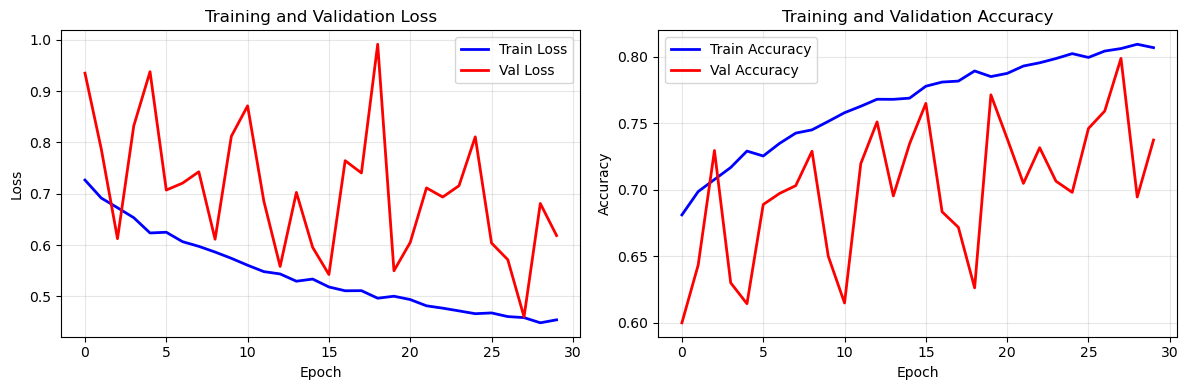

Final Train Loss: 0.4544
Final Val Loss: 0.6186
Final Train Accuracy: 0.8067
Final Val Accuracy: 0.7373
Best Val Accuracy: 0.7986


In [23]:
train_losses, val_losses, train_accs, val_accs = history['train_loss'], history['val_loss'], history['train_acc'], history['val_acc']
    
    # Создаем subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # График потерь
ax1.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
    
    # График точности
ax2.plot(train_accs, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, 'r-', label='Val Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()
    
    # Вывод финальных результатов
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final Train Accuracy: {train_accs[-1]:.4f}")
print(f"Final Val Accuracy: {val_accs[-1]:.4f}")
print(f"Best Val Accuracy: {max(val_accs):.4f}")

Переобучения в модели не обнаружено, загрузим лучшую модель и продолжим обучение.

In [25]:
def load_model_for_training(checkpoint_path, model_class):

    # Загружаем чекпоинт
    checkpoint = torch.load(checkpoint_path)
    
    # Создаем модель той же архитектуры
    model = model_class()
    
    # Загружаем веса модели
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Создаем оптимизатор
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Загружаем состояние оптимизатора
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Информация из чекпоинта
    epoch = checkpoint.get('epoch', 0)
    train_loss = checkpoint.get('train_loss', 0)
    val_loss = checkpoint.get('val_loss', 0)
    train_acc = checkpoint.get('train_acc', 0)
    val_acc = checkpoint.get('val_acc', 0)
    classes = checkpoint.get('classes', [])
    
    print(f"Модель загружена из: {checkpoint_path}")
    print(f"Эпоха: {epoch}")
    print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}")
    
    return model, optimizer, checkpoint

In [27]:
parametr = load_model_for_training('best_model.pth', CNNClassifier)

Модель загружена из: best_model.pth
Эпоха: 27
Val loss: 0.4603, Val accuracy: 0.7986


In [28]:
history_2 = train_model_minimal(model, train_loader, test_loader, 30, lr=0.0001)

Обучение на устройстве: cuda
Количество классов: 4
Эпох: 30


Эпоха 1/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:59<00:00,  2.13s/it, loss=0.4229, acc=0.872]



Эпоха 1/30 | Время: 336.0s
Train: Loss = 0.4467, Accuracy = 0.8099 (15550/19200)
Val:   Loss = 0.6563, Accuracy = 0.7342 (5232/7126)
✓ Сохранена лучшая модель (loss: 0.6563)


Эпоха 2/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:39<00:00,  1.77s/it, loss=0.0303, acc=0.988]



Эпоха 2/30 | Время: 315.9s
Train: Loss = 0.4390, Accuracy = 0.8122 (15595/19200)
Val:   Loss = 0.6503, Accuracy = 0.7237 (5157/7126)
✓ Сохранена лучшая модель (loss: 0.6503)


Эпоха 3/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:39<00:00,  1.77s/it, loss=0.1759, acc=0.965]



Эпоха 3/30 | Время: 285.6s
Train: Loss = 0.4354, Accuracy = 0.8158 (15663/19200)
Val:   Loss = 0.4376, Accuracy = 0.8122 (5788/7126)
✓ Сохранена лучшая модель (loss: 0.4376)


Эпоха 4/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:39<00:00,  1.77s/it, loss=0.0587, acc=0.977]



Эпоха 4/30 | Время: 276.6s
Train: Loss = 0.4365, Accuracy = 0.8159 (15666/19200)
Val:   Loss = 0.4342, Accuracy = 0.8187 (5834/7126)
✓ Сохранена лучшая модель (loss: 0.4342)


Эпоха 5/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:38<00:00,  1.77s/it, loss=0.0892, acc=0.988]



Эпоха 5/30 | Время: 276.6s
Train: Loss = 0.4327, Accuracy = 0.8156 (15659/19200)
Val:   Loss = 0.4722, Accuracy = 0.7992 (5695/7126)


Эпоха 6/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:38<00:00,  1.76s/it, loss=0.3327, acc=0.895]



Эпоха 6/30 | Время: 276.2s
Train: Loss = 0.4197, Accuracy = 0.8225 (15792/19200)
Val:   Loss = 0.4642, Accuracy = 0.8062 (5745/7126)


Эпоха 7/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:38<00:00,  1.76s/it, loss=0.3232, acc=0.907]



Эпоха 7/30 | Время: 276.0s
Train: Loss = 0.4258, Accuracy = 0.8185 (15715/19200)
Val:   Loss = 0.4953, Accuracy = 0.7944 (5661/7126)


Эпоха 8/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:38<00:00,  1.76s/it, loss=0.3717, acc=0.884]



Эпоха 8/30 | Время: 276.2s
Train: Loss = 0.4157, Accuracy = 0.8252 (15844/19200)
Val:   Loss = 0.7047, Accuracy = 0.7004 (4991/7126)


Эпоха 9/30 [Val]: 100%|████████████████████████████████████████| 56/56 [01:38<00:00,  1.76s/it, loss=0.1411, acc=0.953]



Эпоха 9/30 | Время: 276.5s
Train: Loss = 0.4147, Accuracy = 0.8234 (15810/19200)
Val:   Loss = 0.4563, Accuracy = 0.8034 (5725/7126)


Эпоха 10/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:38<00:00,  1.76s/it, loss=0.2495, acc=0.919]



Эпоха 10/30 | Время: 277.1s
Train: Loss = 0.4133, Accuracy = 0.8246 (15833/19200)
Val:   Loss = 1.0785, Accuracy = 0.6329 (4510/7126)


Эпоха 11/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:38<00:00,  1.77s/it, loss=0.0097, acc=0.988]



Эпоха 11/30 | Время: 276.4s
Train: Loss = 0.4137, Accuracy = 0.8219 (15781/19200)
Val:   Loss = 0.7541, Accuracy = 0.7320 (5216/7126)


Эпоха 12/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:38<00:00,  1.76s/it, loss=0.0847, acc=0.977]



Эпоха 12/30 | Время: 277.0s
Train: Loss = 0.4069, Accuracy = 0.8284 (15906/19200)
Val:   Loss = 0.7874, Accuracy = 0.7084 (5048/7126)


Эпоха 13/30 [Val]: 100%|███████████████████████████████████████| 56/56 [02:02<00:00,  2.18s/it, loss=0.0482, acc=0.988]



Эпоха 13/30 | Время: 302.0s
Train: Loss = 0.4053, Accuracy = 0.8306 (15948/19200)
Val:   Loss = 0.5280, Accuracy = 0.7722 (5503/7126)


Эпоха 14/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:52<00:00,  2.02s/it, loss=0.0624, acc=0.988]



Эпоха 14/30 | Время: 343.2s
Train: Loss = 0.3997, Accuracy = 0.8296 (15928/19200)
Val:   Loss = 0.3931, Accuracy = 0.8277 (5898/7126)
✓ Сохранена лучшая модель (loss: 0.3931)


Эпоха 15/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:47<00:00,  1.92s/it, loss=0.0059, acc=1.000]



Эпоха 15/30 | Время: 312.8s
Train: Loss = 0.4032, Accuracy = 0.8289 (15914/19200)
Val:   Loss = 0.7273, Accuracy = 0.7104 (5062/7126)


Эпоха 16/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:51<00:00,  2.00s/it, loss=0.5454, acc=0.814]



Эпоха 16/30 | Время: 309.4s
Train: Loss = 0.3936, Accuracy = 0.8331 (15995/19200)
Val:   Loss = 0.4957, Accuracy = 0.8055 (5740/7126)


Эпоха 17/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:52<00:00,  2.00s/it, loss=0.1844, acc=0.965]



Эпоха 17/30 | Время: 315.3s
Train: Loss = 0.3916, Accuracy = 0.8330 (15993/19200)
Val:   Loss = 0.4620, Accuracy = 0.7964 (5675/7126)


Эпоха 18/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:52<00:00,  2.01s/it, loss=0.1361, acc=0.965]



Эпоха 18/30 | Время: 313.7s
Train: Loss = 0.3882, Accuracy = 0.8382 (16093/19200)
Val:   Loss = 0.4549, Accuracy = 0.8016 (5712/7126)


Эпоха 19/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:53<00:00,  2.03s/it, loss=0.3183, acc=0.919]



Эпоха 19/30 | Время: 315.9s
Train: Loss = 0.3864, Accuracy = 0.8385 (16099/19200)
Val:   Loss = 0.5287, Accuracy = 0.7830 (5580/7126)


Эпоха 20/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:48<00:00,  1.93s/it, loss=0.0855, acc=0.965]



Эпоха 20/30 | Время: 307.7s
Train: Loss = 0.3805, Accuracy = 0.8391 (16111/19200)
Val:   Loss = 0.4616, Accuracy = 0.8023 (5717/7126)


Эпоха 21/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:59<00:00,  2.13s/it, loss=0.5003, acc=0.872]



Эпоха 21/30 | Время: 351.5s
Train: Loss = 0.3797, Accuracy = 0.8390 (16109/19200)
Val:   Loss = 0.5211, Accuracy = 0.7964 (5675/7126)


Эпоха 22/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:59<00:00,  2.13s/it, loss=0.0505, acc=0.988]



Эпоха 22/30 | Время: 336.5s
Train: Loss = 0.3775, Accuracy = 0.8395 (16118/19200)
Val:   Loss = 0.3922, Accuracy = 0.8330 (5936/7126)
✓ Сохранена лучшая модель (loss: 0.3922)


Эпоха 23/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:59<00:00,  2.13s/it, loss=0.0136, acc=1.000]



Эпоха 23/30 | Время: 341.0s
Train: Loss = 0.3728, Accuracy = 0.8423 (16172/19200)
Val:   Loss = 0.4779, Accuracy = 0.7967 (5677/7126)


Эпоха 24/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:59<00:00,  2.14s/it, loss=0.1000, acc=0.965]



Эпоха 24/30 | Время: 336.8s
Train: Loss = 0.3706, Accuracy = 0.8459 (16242/19200)
Val:   Loss = 0.4203, Accuracy = 0.8169 (5821/7126)


Эпоха 25/30 [Val]: 100%|███████████████████████████████████████| 56/56 [02:03<00:00,  2.20s/it, loss=0.3096, acc=0.919]



Эпоха 25/30 | Время: 377.0s
Train: Loss = 0.3722, Accuracy = 0.8436 (16197/19200)
Val:   Loss = 0.5585, Accuracy = 0.7741 (5516/7126)


Эпоха 26/30 [Val]: 100%|███████████████████████████████████████| 56/56 [02:00<00:00,  2.15s/it, loss=0.2131, acc=0.930]



Эпоха 26/30 | Время: 461.8s
Train: Loss = 0.3763, Accuracy = 0.8403 (16134/19200)
Val:   Loss = 0.5452, Accuracy = 0.7742 (5517/7126)


Эпоха 27/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:59<00:00,  2.14s/it, loss=0.0522, acc=0.988]



Эпоха 27/30 | Время: 343.2s
Train: Loss = 0.3655, Accuracy = 0.8442 (16209/19200)
Val:   Loss = 0.3796, Accuracy = 0.8392 (5980/7126)
✓ Сохранена лучшая модель (loss: 0.3796)


Эпоха 28/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:48<00:00,  1.94s/it, loss=0.7526, acc=0.802]



Эпоха 28/30 | Время: 313.3s
Train: Loss = 0.3711, Accuracy = 0.8414 (16155/19200)
Val:   Loss = 0.6421, Accuracy = 0.7506 (5349/7126)


Эпоха 29/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:50<00:00,  1.98s/it, loss=0.0333, acc=0.988]



Эпоха 29/30 | Время: 304.3s
Train: Loss = 0.3635, Accuracy = 0.8494 (16308/19200)
Val:   Loss = 0.4915, Accuracy = 0.8000 (5701/7126)


Эпоха 30/30 [Val]: 100%|███████████████████████████████████████| 56/56 [01:52<00:00,  2.01s/it, loss=0.2256, acc=0.942]


Эпоха 30/30 | Время: 332.1s
Train: Loss = 0.3595, Accuracy = 0.8488 (16297/19200)
Val:   Loss = 1.9256, Accuracy = 0.5487 (3910/7126)

ОБУЧЕНИЕ ЗАВЕРШЕНО!
Лучшая точность валидации: 0.8392
Лучший loss валидации: 0.3796
Финальная точность валидации: 0.5487


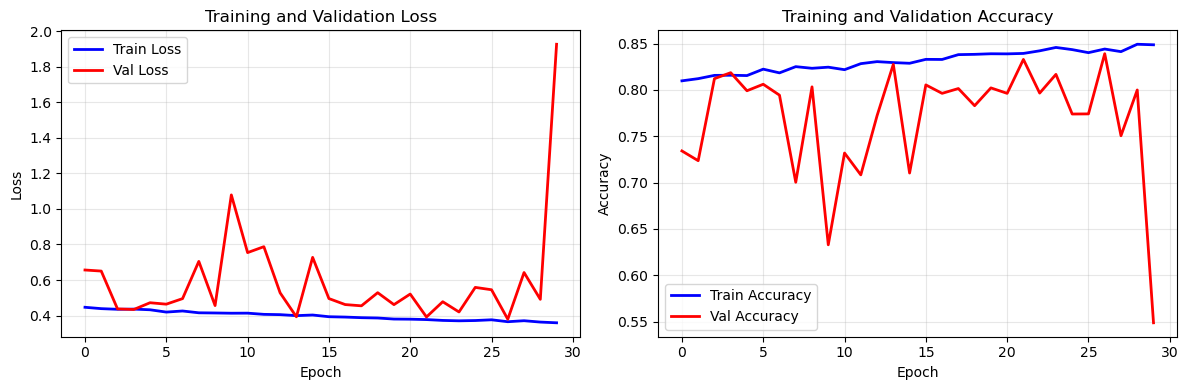

Final Train Loss: 0.3595
Final Val Loss: 1.9256
Final Train Accuracy: 0.8488
Final Val Accuracy: 0.5487
Best Val Accuracy: 0.8392


In [29]:
train_losses, val_losses, train_accs, val_accs = history_2['train_loss'], history_2['val_loss'], history_2['train_acc'], history_2['val_acc']
    
    # Создаем subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # График потерь
ax1.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
    
    # График точности
ax2.plot(train_accs, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, 'r-', label='Val Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()
    
    # Вывод финальных результатов
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final Train Accuracy: {train_accs[-1]:.4f}")
print(f"Final Val Accuracy: {val_accs[-1]:.4f}")
print(f"Best Val Accuracy: {max(val_accs):.4f}")

In [30]:
parametr_2 = load_model_for_training('best_model.pth', CNNClassifier)

Модель загружена из: best_model.pth
Эпоха: 26
Val loss: 0.3796, Val accuracy: 0.8392


График стал  более пологим и модель вероятно достигла своего максимума, но тем не менее на дообучении удалось поднять метрику accurace на 4 процента. Сохранее лучшей модели произошло успешно.

# Итог
Удалось обучить модель для классификации настроения с итоговой метрикой точности 0,84. Сама модель состоит из:
* Сверточная часть - 5 блоков сверточных слоев с ядром свертки 5х5, слоями пуллинга и бэнчнормолайзами
* Классификационная часть - 3 полносвязных слоя, между которыми слои Dropout и BanchNormalize
 